# Analysis 3.2
- Model: XGBoost
- Feature selection: Significant variables based on univariate analysis
- Drop patients with missing sex 
- Predicts 10 year risk for combined UGI cancer
- Risk score threshold determined on optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from scipy.stats import percentileofscore
from pathlib import Path
from functools import reduce
from helpers.utils import generate_risk_percentile_df, classification_metrics

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss, confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score
import xgboost as xgb
import numpy as np


In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R 
source("utils.R")
library(survival)
library(xgboost)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
model = 'xgb'
cancer = 'ugica'
ro.globalenv['model'] = model
ro.globalenv['cancer'] = cancer

analysis_num = '3.2'

In [8]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

outcome_interval <- "_10yr"
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), outcome_interval)
model_filename <- paste0(model, "_", outcome_event, ".rds")

In [9]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
outcome_event = r['outcome_event'][0]
outcome_interval = r['outcome_interval'][0]


In [10]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## XGBoost with manual feature selection

#### Clean up features

In [11]:
%%R 
selected_vars <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore 
]
selected_vars

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


#### Split dataset into training and validation
Use R to ensure similar dataset as prior analyses

In [12]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

[1] "Dataset Controls 33890" "Dataset Cases 293"     
[1] "Training Controls 27115" "Training Cases 232"     
[1] "Validation Controls 6775" "Validation Cases 61"     



In [13]:
r_df_train = r['train_set']
df_train = pandas2ri.rpy2py(r_df_train)

r_df_validation = r['validation_set']
df_validation = pandas2ri.rpy2py(r_df_validation)

df_train.shape, df_validation.shape


((27347, 49), (6836, 49))

In [14]:
cols_to_stratify = r['cols_to_stratify']
cols_to_stratify

array(['race_clean', 'sex_missing', 'age_bucket', 'visit_year_bucket'],
      dtype='<U17')

In [15]:
cols_to_remove = ['age_bucket', 'visit_year_bucket',
    'months_to_event', 'ugica', 'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC',
    'ugica_10yr', 'ugica_5yr', 'ugica_3yr', 'ugica_1yr', 
    'escc_10yr', 'escc_5yr', 'escc_3yr', 'escc_1yr', 
    'eac_10yr', 'eac_5yr', 'eac_3yr', 'eac_1yr', 
    'cgc_10yr', 'cgc_5yr', 'cgc_3yr', 'cgc_1yr', 
    'ncgc_10yr', 'ncgc_5yr', 'ncgc_3yr', 'ncgc_1yr'
]

X_train = df_train.drop(columns=[outcome_event] + list(cols_to_remove))
X_validation = df_validation.drop(columns=[outcome_event] + list(cols_to_remove))

y_train = df_train.loc[:, outcome_event]
y_validation = df_validation.loc[:, outcome_event]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape


((27347, 21), (27347,), (6836, 21), (6836,))

In [16]:
# Encode categorical columns using label encoding for XGBClassifier
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:
	print(f"Encoding column: {col}")
	le = LabelEncoder()
	X_train[col] = le.fit_transform(X_train[col])
	X_validation[col] = le.transform(X_validation[col])
	label_encoders[col] = le


Encoding column: sex_missing
Encoding column: race_clean
Encoding column: ethnicity


In [17]:
# Train an XGBClassifier without any manual feature selection
model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, max_depth=3, reg_alpha=0.7, reg_lambda=1.2)
model.fit(X_train, y_train)

# Train with the top 10 features based on feature importance scores 
importance_scores = model.feature_importances_
selected_features = importance_scores.argsort()[-10:]
selected_model = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, max_depth=3, reg_alpha=0.7, reg_lambda=1.2)
selected_model.fit(X_train.iloc[:, selected_features], y_train)

# Using scikit-learn's SelectFromModel for feature selection
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train)
X_validation_selected = selector.transform(X_validation)
selected_model_pipeline = xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, max_depth=3, reg_alpha=0.7, reg_lambda=1.2)
selected_model_pipeline.fit(X_train_selected, y_train)

# Evaluate the original model
y_pred = model.predict_proba(X_validation)[:, 1]
original_auroc = roc_auc_score(y_validation, y_pred)

# Evaluate the model with selected features
y_pred_selected = selected_model.predict_proba(X_validation.iloc[:, selected_features])[:, 1]
selected_auroc = roc_auc_score(y_validation, y_pred_selected)

# Evaluate the model with selected features using the pipeline
y_pred_pipeline = selected_model_pipeline.predict_proba(X_validation_selected)[:, 1]
selected_auroc_pipeline = roc_auc_score(y_validation, y_pred_pipeline)

print(f"Original Model AUROC: {original_auroc:.4f}")
print(f"Selected Features Model AUROC: {selected_auroc:.4f}")
print(f"Selected Features Model AUROC (Pipeline): {selected_auroc_pipeline:.4f}")

Original Model AUROC: 0.7818
Selected Features Model AUROC: 0.7643
Selected Features Model AUROC (Pipeline): 0.7416


In [18]:
# Set the model to the one with the best AUROC
models = [model, selected_model, selected_model_pipeline]
aurocs = [original_auroc, selected_auroc, selected_auroc_pipeline]
y_preds = [y_pred, y_pred_selected, y_pred_pipeline]

best_model = None
best_auroc = -1
best_pred = None

for i, auroc in enumerate(aurocs):
    if auroc > best_auroc:
        best_model = models[i]
        best_auroc = auroc
        best_pred = y_preds[i]

print(f"Best Model AUROC: {best_auroc:.4f}")

Best Model AUROC: 0.7818


In [19]:
ro.globalenv["pred_risk"] = best_pred
ro.globalenv["actual_event"] = y_validation

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.782 
Sensitivity: 0.7377049 
Specificity: 0.7279705 
PPV: 0.02383475 
NPV: 0.9967664 
NNS: 48.54106 
     predicted_class
event    0    1
    0 4932 1843
    1   16   45


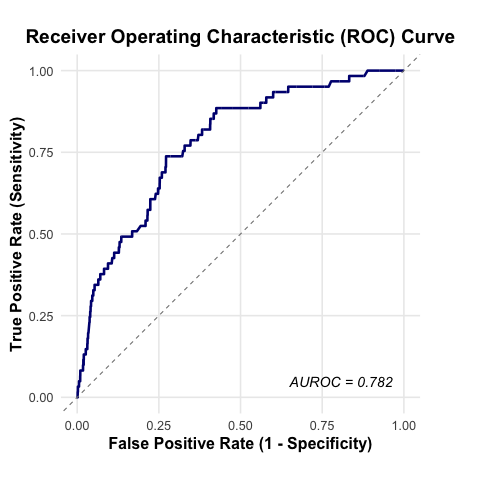

In [20]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = actual_event, predictor = pred_risk)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(pred_risk, actual_event, optimal_threshold)

# Plot ROC 
p1 <- plot_roc_gg(actual_event, pred_risk)
p1

In [21]:
df_validation_risk = df_validation.copy()
df_validation_risk['pred_risk'] = best_pred
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk['pred_risk'], optimal_threshold, kind='weak')/100.
print(optimal_threshold_percentile)
percentile_cutoffs = [0.4, 0.5, 0.6, 0.8, 0.9, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, 'pred_risk', percentile_cutoffs, optimal_threshold)

0.7238150965476887


In [22]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race_clean.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex_missing.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race_clean == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex_missing == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  nns = 1/aer


In [23]:
df_results[df_results.risk_percentile == optimal_threshold_percentile]

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
25,risk_p0.7238150965476887,0.723815,ugica_10yr,all,6775,61,4621,50 (1.1%),1.1,50,4571,11,2204,0.329725,0.670275,81.967213,32.531365,1.082017,99.503386,170.822527,0.144986
26,risk_p0.7238150965476887,0.723815,escc_10yr,all,6820,16,4621,10 (0.2%),0.2,10,4611,6,2209,0.324605,0.675395,62.500000,32.390029,0.216403,99.729120,-1835.637554,-0.051100
27,risk_p0.7238150965476887,0.723815,eac_10yr,all,6824,12,4621,10 (0.2%),0.2,10,4611,2,2213,0.325190,0.674810,83.333333,32.429660,0.216403,99.909707,792.959018,0.157630
28,risk_p0.7238150965476887,0.723815,cgc_10yr,all,6822,14,4621,13 (0.3%),0.3,13,4608,1,2214,0.325775,0.674225,92.857143,32.453826,0.281324,99.954853,423.410069,0.253110
29,risk_p0.7238150965476887,0.723815,ncgc_10yr,all,6817,19,4621,17 (0.4%),0.4,17,4604,2,2213,0.326214,0.673786,89.473684,32.462960,0.367886,99.909707,360.240559,0.219366


In [24]:
df_results.to_csv(risk_results_filename)

In [25]:
# Get the best model's features and importances
feature_names = None 
if best_model == model:
    feature_names = X_train.columns
elif best_model == selected_model:
    feature_names =  X_train.columns[selected_features]
elif best_model == selected_model_pipeline:
    selected_feature_indices = selector.get_support(indices=True)
    feature_names = X_train.columns[selected_feature_indices]

importances = best_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    "term": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Pass to R
%R -i importance_df

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "term". Fall back to string conversion. The error is: <class 'numpy.str_'>
  warnings.warn('Error while trying to convert '


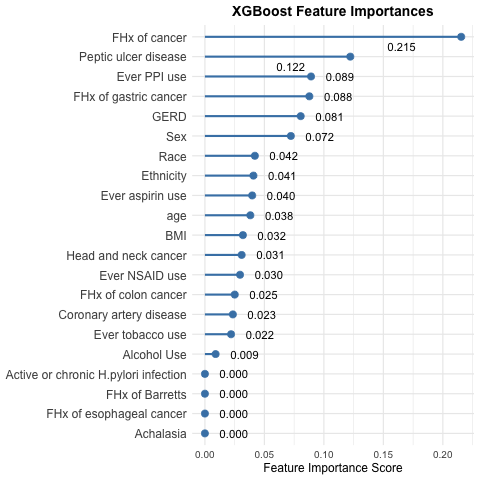

In [26]:
%%R
library(dplyr)
library(ggplot2)

# Use pretty names if available
pretty_names <- c(
  "ethnicity" = "Ethnicity",
  "alcohol_binary" = "Alcohol Use",
  "ASA" = "Ever aspirin use",
  "tobacco_binary" = "Ever tobacco use",
  "NSAID" = "Ever NSAID use",
  "race_clean" = "Race",
  "age_scaled" = "Age",
  "sex_missing" = "Sex",
  "famhx_gastricca" = "FHx of gastric cancer",
  "hpylori_active_chronic_binary" = "Active or chronic H.pylori infection",
  "PPI" = "Ever PPI use",
  "cad" = "Coronary artery disease", 
  "famhx_cancer" = "FHx of cancer",
  "famhx_colonca" = "FHx of colon cancer",
  "gerd" = "GERD",
  "pud" = "Peptic ulcer disease",
  "hnca" = "Head and neck cancer",
  "height_baseline" = "Height",
  "weight_baseline" = "Weight",
  "BMI_baseline_all" = "BMI",
  "famhx_esophagealca" = "FHx of esophageal cancer",
  "famhx_barretts" = "FHx of Barretts",
  "achalasia" = "Achalasia"
)

# Format the dataframe
importance_df <- importance_df %>%
  mutate(
    Variable_pretty = pretty_names[term],
    Variable_pretty = ifelse(is.na(Variable_pretty), term, Variable_pretty),
    imp_label = sprintf("%.3f", importance),
  ) %>%
  arrange(importance) %>%
  mutate(Variable_pretty = factor(Variable_pretty, levels = Variable_pretty)) %>%
  mutate(y_pos = as.numeric(Variable_pretty))
  

# Plot as a forest-style plot
ggplot(importance_df, aes(x = importance, y = Variable_pretty)) +
  geom_point(color = "steelblue", size = 3) +
  
  # Labels for importance >= 0.1 (under the segment)
  geom_text(
    data = subset(importance_df, importance >= 0.1),
    aes(x = importance - 0.05, y = y_pos - 0.5, label = imp_label),
    hjust = 0.5, size = 4
  ) +

  # Labels for importance < 0.1 (right of the dot)
  geom_text(
    data = subset(importance_df, importance < 0.1),
    aes(x = importance + 0.01, y = Variable_pretty, label = imp_label),
    hjust = -0.1, size = 4
  ) +
  
  geom_segment(aes(x = 0, xend = importance, y = Variable_pretty, yend = Variable_pretty),
               color = "steelblue", size = 1) +
  labs(
    title = "XGBoost Feature Importances",
    x = "Feature Importance Score",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5)
  )
